In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device : ', device)

In [2]:
# only for mac
device = 'mps'

In [3]:
# 0~1, -1~1
transform = transforms.Compose([
    # 0 ~ 1
    transforms.ToTensor(),
    # (0 - 0.5) / 0.5 --> -1 /  (1 -0.5)/0.5 --> 1 # -1~1
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # (mean), (std) for each channel --> (data - mean) / std
    # flip 좌우반전
    transforms.RandomHorizontalFlip(p=0.5),
])

# 0~1, -1~1
transform_test = transforms.Compose([
    # 0 ~ 1
    transforms.ToTensor(),
    # (0 - 0.5) / 0.5 --> -1 /  (1 -0.5)/0.5 --> 1 # -1~1
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # (mean), (std) for each channel --> (data - mean) / std
])

In [4]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

In [7]:
# output = input-kernel+(2*padding) / stride + 1
# output = 32 - 3 + (2) / 1 + 1

class AlexNet(nn.Module) :
    def __init__(self) :
        super(AlexNet, self).__init__()
        self.name = "AlexNet"
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=(4, 4)),
            nn.ReLU(inplace=True),
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=(5, 5), padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.fc_layer1 = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(9216, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10)
        )

    def forward(self, x) :
        output = self.conv_layer1(x)
        output = self.conv_layer2(output)
        output = self.conv_layer3(output)
        output = output.view(-1, 9216)
        output = self.fc_layer1(output)
        return output

In [8]:
class simple_cnn(nn.Module):
  def __init__(self):
    #32/32/3
    super(simple_cnn, self).__init__()

    self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3,3) ),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=4, out_channels=16, kernel_size=(3,3) ),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2 ),

        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3)),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # 5*5*16
    )
    # fc layer Linear

    self.fc_layer = nn.Sequential(
        nn.Dropout(0.5), 
        nn.Linear(16*5*5, 64),
        nn.ReLU(inplace=True), 
        nn.Linear(64, 32),
        nn.ReLU(inplace=True),
        nn.Linear(32, 10),        
    )

  def forward(self, x):
    o = self.conv_layer(x)
    # 5x5x16 # batch size- channel, h, w
    o = o.view(o.shape[0], -1) #numpy reshape
    o = self.fc_layer(o)

    return o


In [9]:
# cnn_net = simple_cnn()
cnn_net = AlexNet()

In [10]:
from torchsummary import summary
# cnn_net = cnn_net.to(device)
summary(cnn_net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 29, 29]           4,704
              ReLU-2           [-1, 96, 29, 29]               0
            Conv2d-3          [-1, 256, 29, 29]         614,656
              ReLU-4          [-1, 256, 29, 29]               0
         MaxPool2d-5          [-1, 256, 14, 14]               0
            Conv2d-6          [-1, 384, 14, 14]         885,120
              ReLU-7          [-1, 384, 14, 14]               0
            Conv2d-8          [-1, 384, 14, 14]       1,327,488
              ReLU-9          [-1, 384, 14, 14]               0
           Conv2d-10          [-1, 256, 14, 14]         884,992
             ReLU-11          [-1, 256, 14, 14]               0
        MaxPool2d-12            [-1, 256, 6, 6]               0
          Dropout-13                 [-1, 9216]               0
           Linear-14                 [-

In [11]:
criterion = nn.CrossEntropyLoss() #
optimizer = optim.Adam(cnn_net.parameters(), lr=0.001)

In [12]:
epochs = 10

In [ ]:
cnn_net = cnn_net.to(device)
for e in range(epochs):
  for it_bat, (img, lab) in enumerate(trainloader):
    img = img.to(device)
    lab = lab.to(device)

    optimizer.zero_grad()
    outputs = cnn_net(img)

    loss = criterion(outputs, lab)
    loss.backward()

    optimizer.step()

    if (it_bat+1) % 100 == 0:
        print(f'epoch{e}, batch{it_bat+1}, loss{loss.item()}')
        with torch.no_grad():
            cnn_net.eval()
            total_cnt =0
            correct_cnt=0
            for it_batch, (img, lab) in enumerate(testloader):
                img = img.to(device)
                lab = lab.to(device)

                total_cnt += img.shape[0]
                outputs = cnn_net(img)

                pred = torch.argmax(outputs, axis=1)
                correct_cnt +=(pred == lab).sum().item()
                
                if it_batch > 2:
                    break;
            print(f'correct{correct_cnt}, total{total_cnt}, acc{correct_cnt/total_cnt*100}')
        cnn_net.train()


epoch0, batch100, loss0.6835160255432129
correct76, total100, acc76.0
correct153, total200, acc76.5
correct229, total300, acc76.33333333333333
correct302, total400, acc75.5


correct7009, total10000, acc70.09


In [16]:
sample = next(iter(testloader))
o = cnn_net(sample[0].to(device))
pred = torch.argmax(o, axis=1).to('cpu')
correct = pred == sample[1]
correct.sum().item()

72

In [17]:
import matplotlib.pyplot as plt

def display_sample(img, gt, pred):
  img = img.numpy()
  img = img.transpose(1, 2, 0)
  img = img * 0.5 + 0.5

  plt.figure(figsize=(3,3))
  title_ = 'gt[%s],pred[%s]' % (classes[gt.item()], classes[pred.item()])
  plt.title(title_)
  plt.imshow(img)
  plt.show()

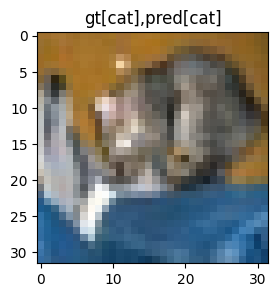

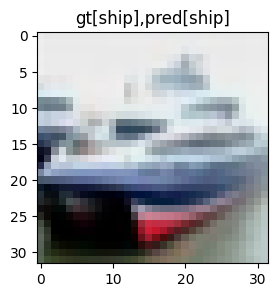

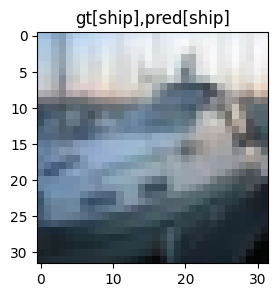

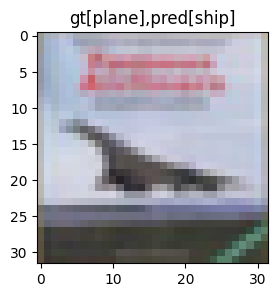

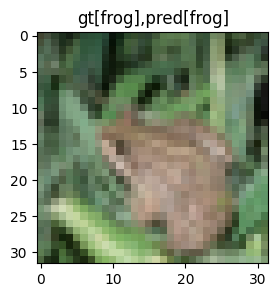

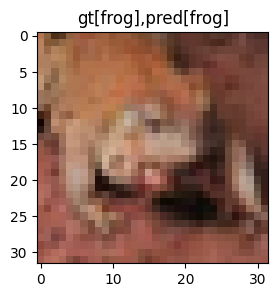

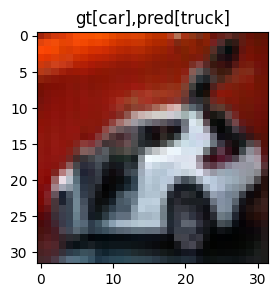

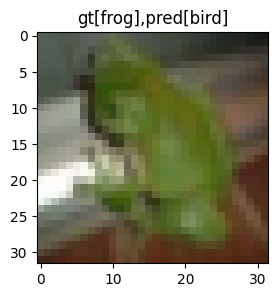

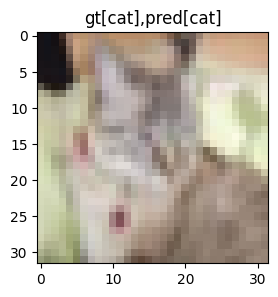

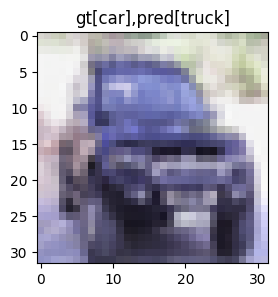

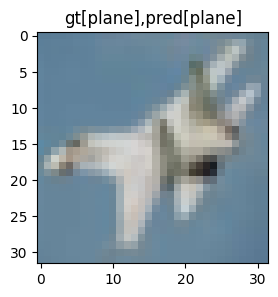

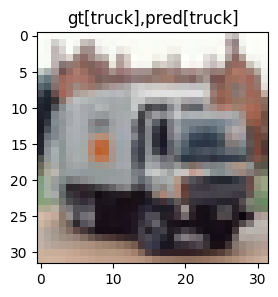

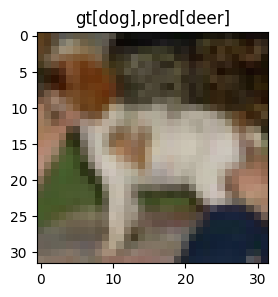

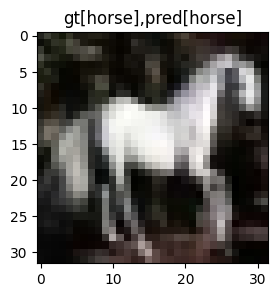

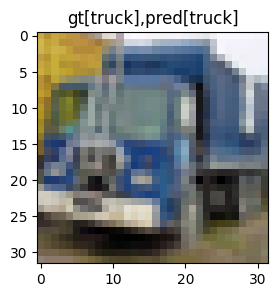

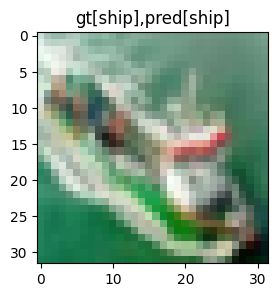

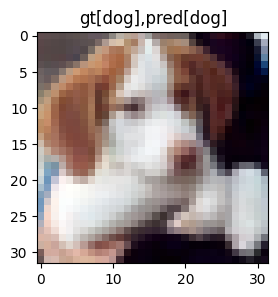

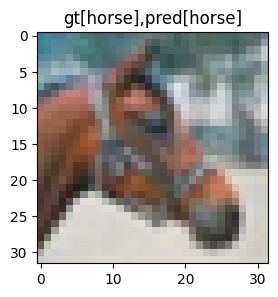

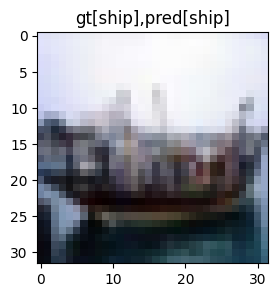

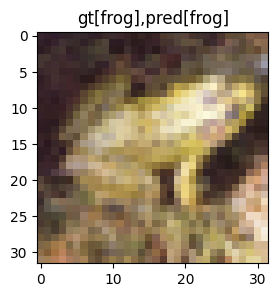

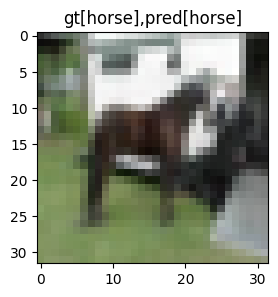

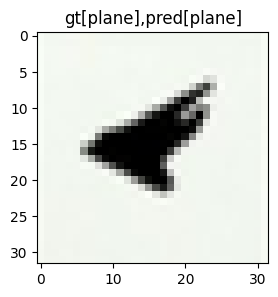

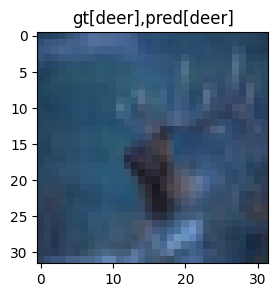

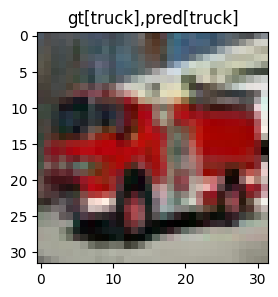

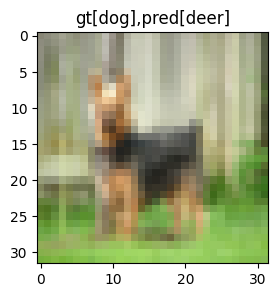

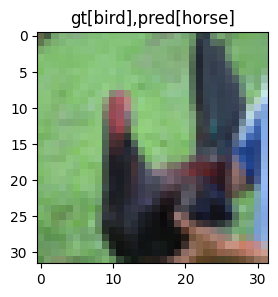

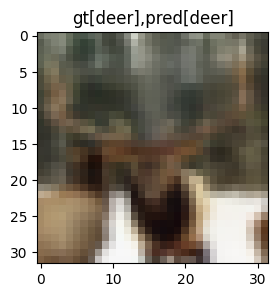

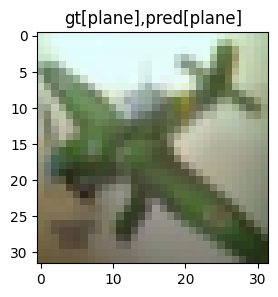

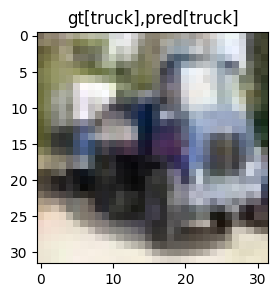

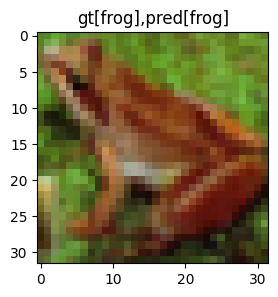

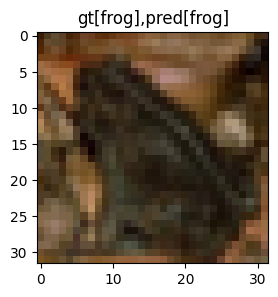

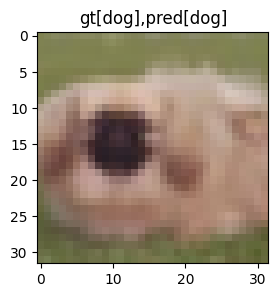

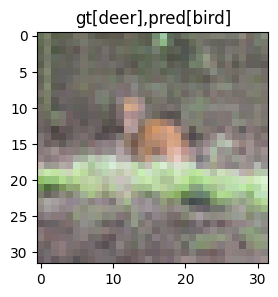

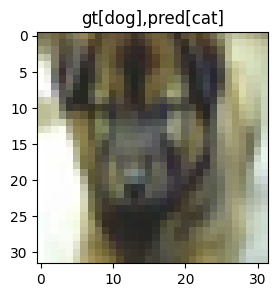

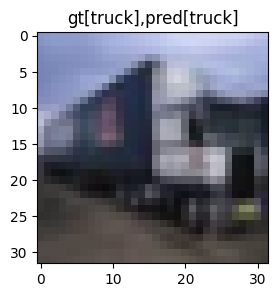

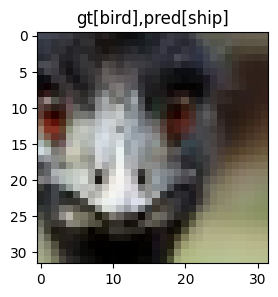

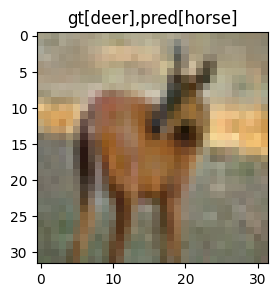

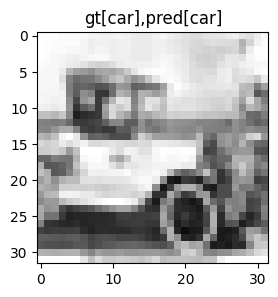

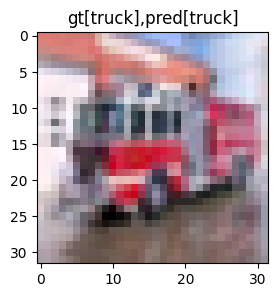

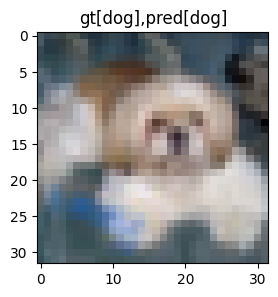

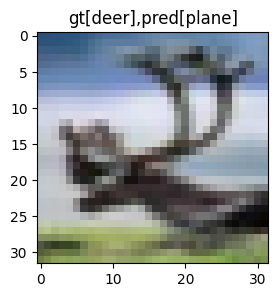

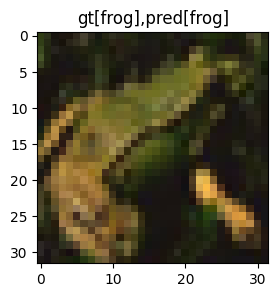

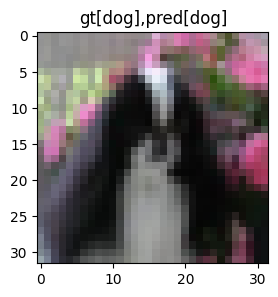

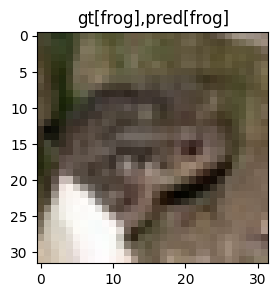

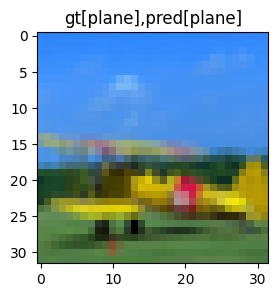

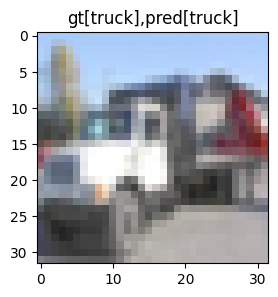

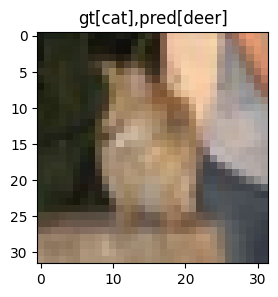

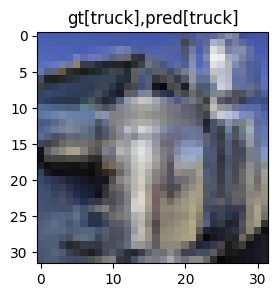

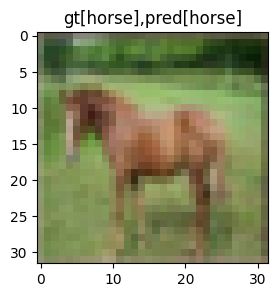

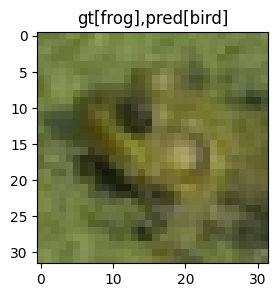

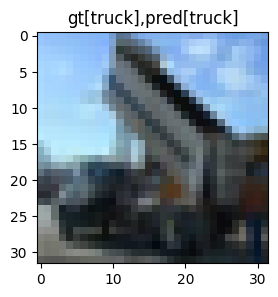

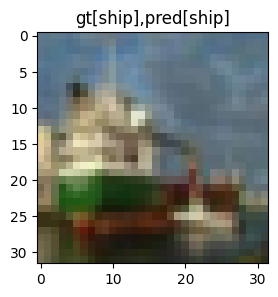

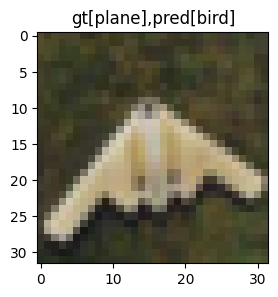

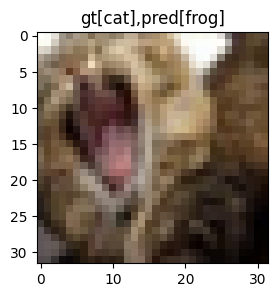

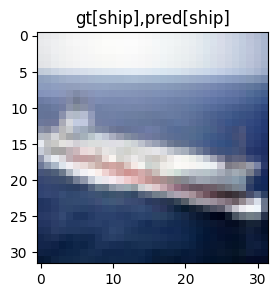

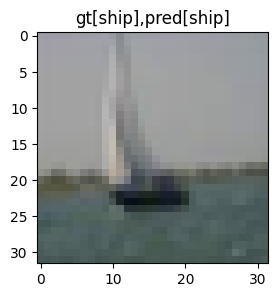

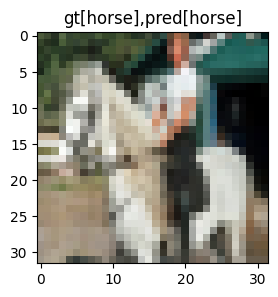

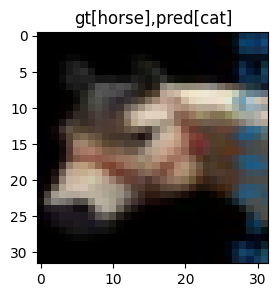

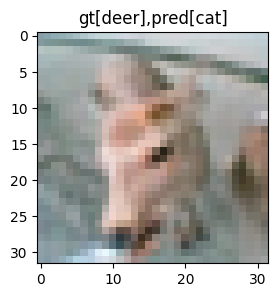

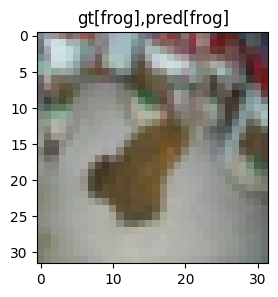

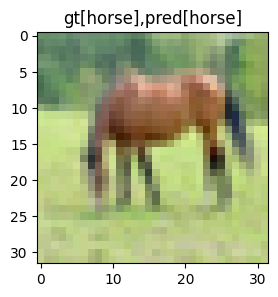

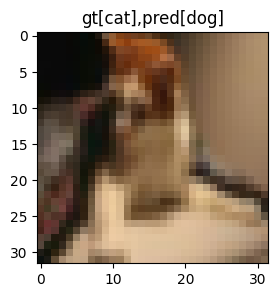

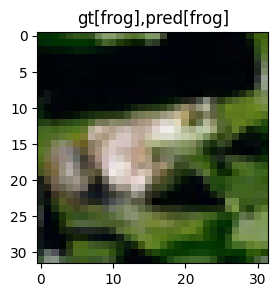

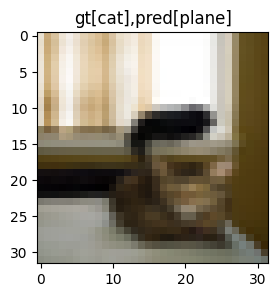

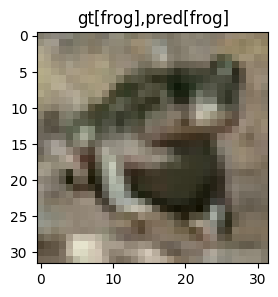

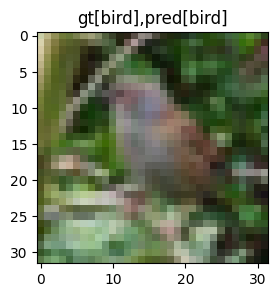

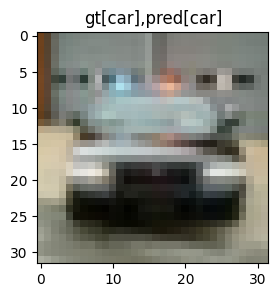

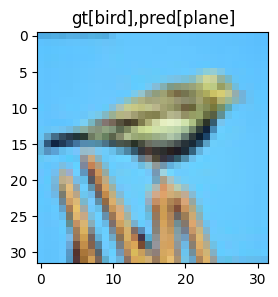

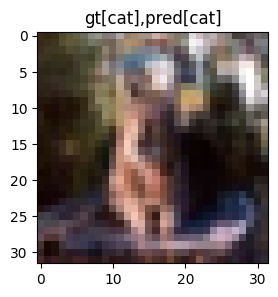

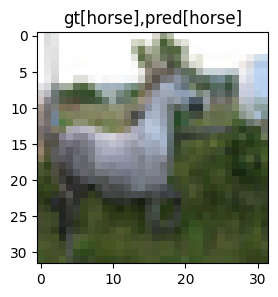

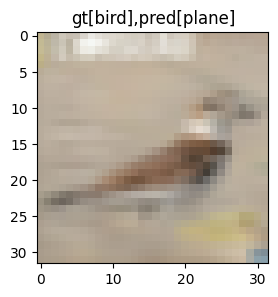

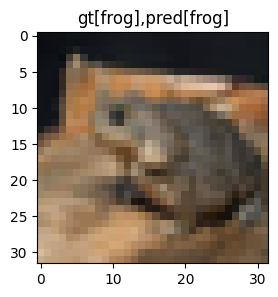

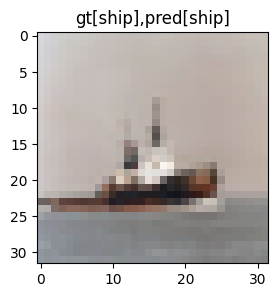

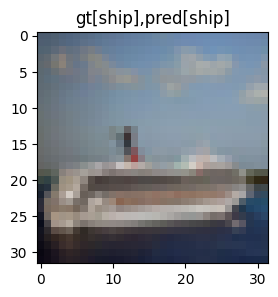

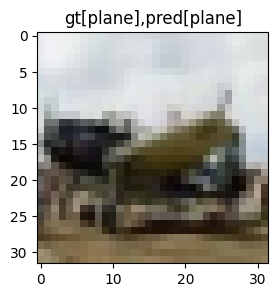

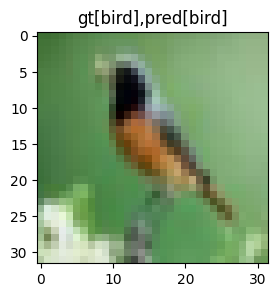

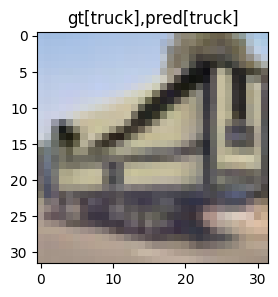

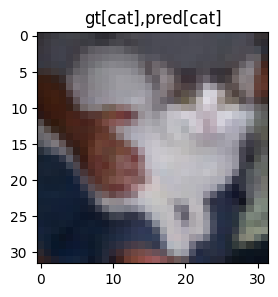

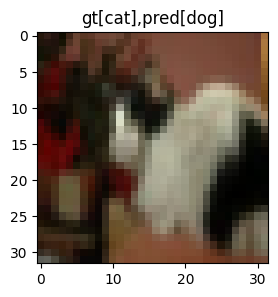

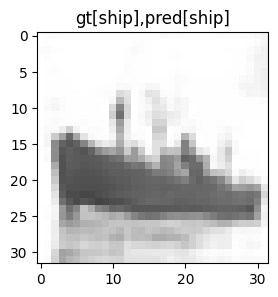

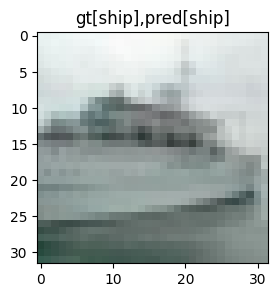

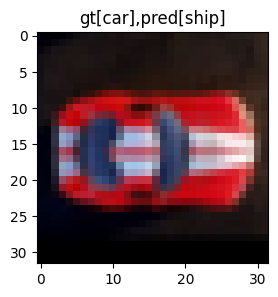

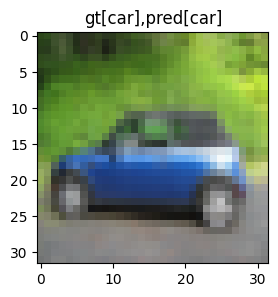

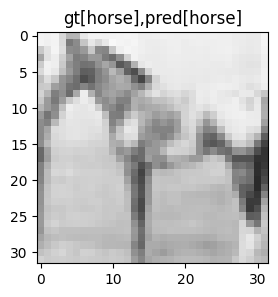

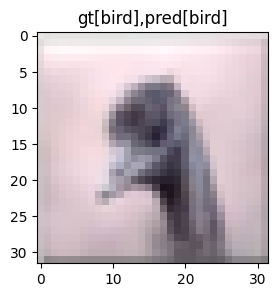

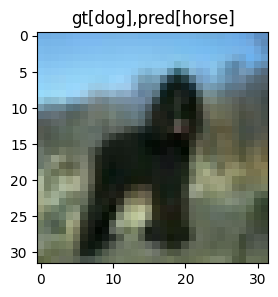

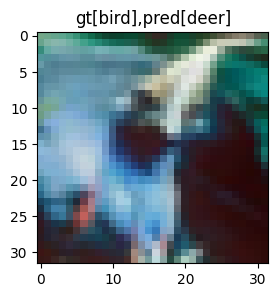

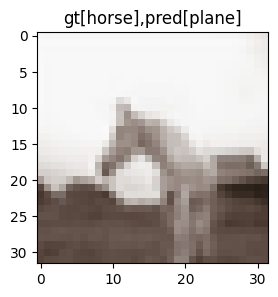

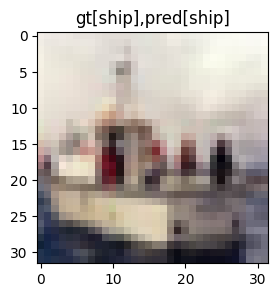

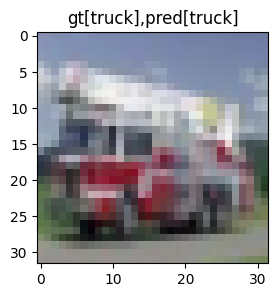

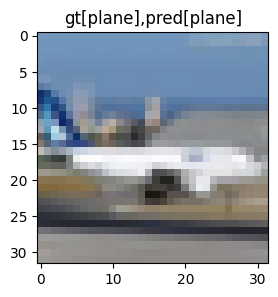

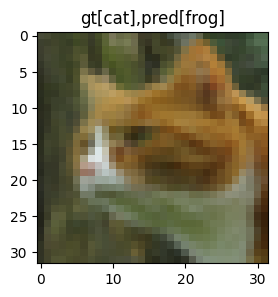

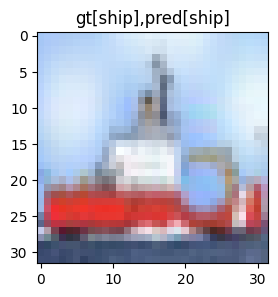

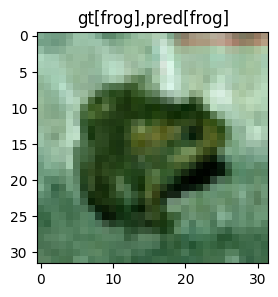

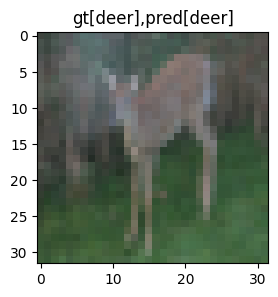

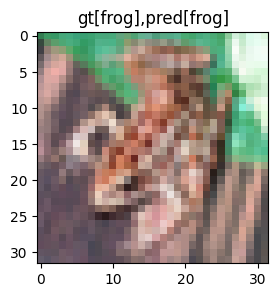

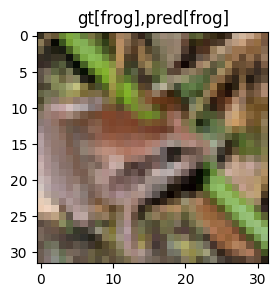

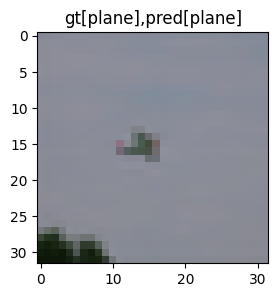

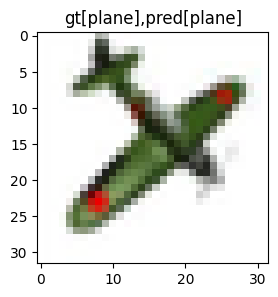

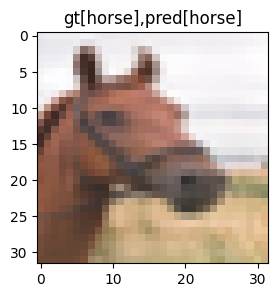

In [18]:
for it_sample in range(sample[0].shape[0]):
  display_sample(sample[0][it_sample], sample[1][it_sample], pred[it_sample])